# Parallel Scaling Guide

## Software Prerequisities for Guide

* Python
    + Jupyter Notebook
    + NumPy
    + mpi4py
    + matplotlib
* Slurm/HPC access (if you want to run the parallel benchmakrs with Slurm)

## Introduction

One of the biggest pros to using high performance computing (HPC) is the ability to use multiple processors, even across multiple computing nodes. However, due to a combination of factors, including but not limited to: algorithm choice, network protocols/bandwidth/throughput, memory, libraries, and CPU-threading, adding more processors doesn't necessarily lead to faster performance. In this guide, we will go through a computing example to show how to measure performance and how best to use HPC resources for a scientific simulation.    

## Prerequisities to use this Guide

## What is parallel scalability?

Parallel scalability is a measurement of how efficient a simulation's runtime is affected by changes in computing resources. For this guide, we will focus on the following two degrees of freedom that are modified to determine paralel scalability:

* Problem size (memory)  
* Number of processors    

## Before considering parallel scalability

Before we can discuss parallel scalability, we need to step back and make sure that:

1. Your software supports a parallelization model
2. The performance of your simulations when using only one processor

### Parallelization Support

There are various paradigms of parallel computing that be used to allow your software to use multiple processors. Some of the most popular programming models include:    

* Message Passing Interface (MPI)
    - OpenMPI
    - MPICH
    - Intel MPI
* OpenMP
* NVIDIA CUDA
* Dask (Python)
    - We will be writing a separate guide for this!
* Hybrid (e.g. MPI+OpenMP)

The choice of  which parallel programming model to use will largely depend on your problem size and resources required. If you need help getting started with parallel programming in your research code, feel free to [reach out for a consultation](https://ciarc.mines.edu)!

### Serial Performance

When running simulations with a single processor, we call this a **serial run**. However, it is recommended to try to make optimizations for how fast your serial run is before you jump into a parallel programming model. Depending on your programming language, there are common tools to profile code. We list some common ones below:

* C/C++ and Fortran: [GNU gprof](http://sourceware.org/binutils/docs/gprof/)
* Python: [cProfile](https://docs.python.org/3/library/profile.html)
* Matlab: [profile](https://www.mathworks.com/help/matlab/matlab_prog/profiling-for-improving-performance.html)

If you need more help profiliing and optimizing your code, feel free to open a ticket at the [Help Desk](https://helpcenter.mines.edu/TDClient/1946/Portal/Requests/ServiceDet?ID=33487) and we'd happy to help you! 

## Measuring Parallel Scalability

### Notation

The table below summarizes the notation we will use for this section.

| Variable      | Description |
| ----------- | ----------- |
| $P$      | Number of processors  |
| $n$   | Problem size (e.g. $n$ is number of mesh cells, etc) |
| $T_{P, max}$      | Max wall time with $P$ processors  |
| $T_{P, avg}$      | Average wall time across $P$ processors  |
| $T_{P, N}$      | Wall time from the $N$-th out of $P$ processors  |
| $S_P$   | Speedup with $P$ processors |
| $E_P$   | Efficiency with $P$ processors |
| $\beta_{P}$   | Load balance with $P$ processors |

### Performance Metrics

In this section we will summarize these common metrics used to benchmark parallel performance. 

#### Wall Time

The base measurement one should use is the wall time of the simulation. However, wall time between each processor ($T_{P,N}$ for processor $N$) 
may be different. Hence, we use two different metrics for wall time, the average $T_{P, max}$ and the processor with the maximum wall time, $T_{P,max}$. For, the derived metrics (speedup, etc), we use $T_{P,max}$. 

#### Speed-up

The first commonly used metric for measuring parallel performance is **speed-up**. This measurement allows one to see how a code scales relative to the serial case. It is typically defined as the ratio of the serial wall time to the parallel (with $P$ processors) wall time:

$$ S_{P} = \frac{T_{1, max}}{T_{P,max}}.$$

We call the speedup **ideal** if $S_{P} = P$, since the the wall time decreases by factor equal to the number of processors. However, in most parallel codes, $S_P < P$. 

#### Efficiency

Another useful derived metric for measuring parallel performance is **efficiency**. This can be thought of as a *relative* speed-up since it measures the fraction of cores are being used in the computation. It is defined by:

$$ E_{P} = \frac{ S_{P} }{P}.$$

Hence, we call it **ideal** efficiency when $E_{P} = 1$. Again, in most parallel codes, $E_P < 1$. 

#### Load balancing

The metrics above give one a sense of the general performance of the parallel code, but it doesn't measure how each core contributes to its performance. Furthermore, we may also want to know if there are bottlenecks caused by communication between cores. One way to measure this is to use a **load balancing** metric:

$$ \beta_P = \frac{ T_{P,avg}}{ T_{P,max} }.$$

Load balancing is **ideal** if $\beta_P = 1$. If you see that your load balance number is very small, i.e. $T_{P,avg} << T_{P,max}$, then you may want to re-examine your parallel components of your code and also look at the individual wall times of each processors to determine where the bottleneck is coming from. 

#### Other metrics

There are other metrics, such as parallel rule of thumb and the Karp-Flatt Balance metric, but we won't get into them here. Please see the references below if you want to learn more!


###  Basic Theory

Although we have practical metrics that can be computated *a posterior* to a simulation, it is helpful to know some theory to better gauge what these metrics can tell us about our parallel performance. In this section, we will go over some basic theory on parallel scaling. We will briefly cover two important Laws with regards to parallel computing: Amdhal's and Gustavon's Laws. We will also discuss their relations to two other important parallel computing concepts: strong and weak scaling. 


#### Amdahl's Law

With any parallel code, there may be limitations on what can actually be paralleizable; some portions of the code may be serial only and can limit the scalability of the code. In 1967, Gene Amdhal proposed a way to predict how much a code can scale due to a serial bottleneck [4]. Amdhal's Law can be summarized with the following equation relating to speedup $S_{P,Am}$[4]:

$$ S_{P,Am} = \frac{1}{F_{s} + \frac{F_{p}}{P}}$$

where $F_{s}$ is the *theoretical* serial fraction spent on the serial portion of the code, while $F_{p}$ is the fraction of the runtime spent on the code that is parallelizable. Hence, $F_p + F_s = 1$ and Amdahl's law can be simplified to:

$$ S_{P,Am}(F_{s}) = \frac{1}{F_{s} + \frac{1-F_{s}}{P}}$$

We can plot this now as a function of $F_{s}$ using Python's scientific modules (numpy, matplotlib):

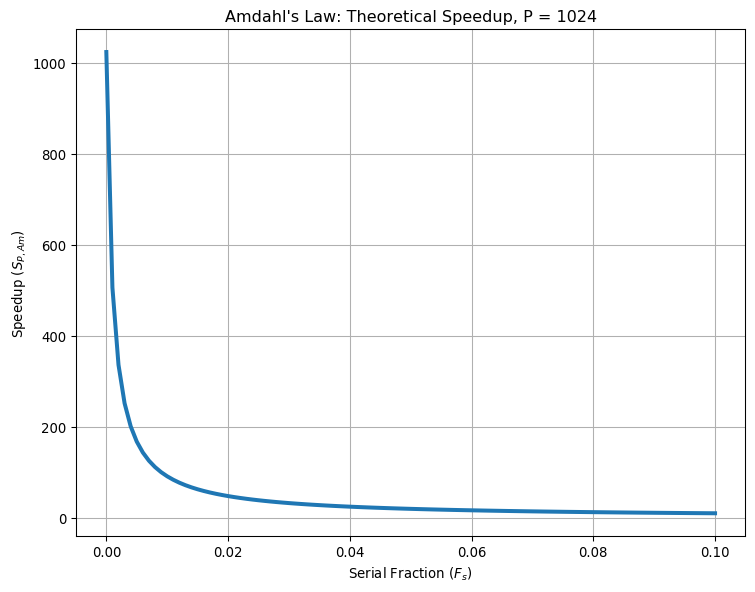

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# define the serial fraction using a linear space in NumPy
N = 101 # plotting grid resolution
F_s = np.linspace(0,0.1,N)
S_P_Am = np.empty(N)

# set the number of processors
P = 1024
S_P_Am[:] = 1.0/( F_s[:] + (1.0-F_s[:])/float(P) )
plt.figure(figsize=(9,7), dpi=96)
plt.plot(F_s,S_P_Am,'-', linewidth=3)
plt.xlabel(r"Serial Fraction ($F_s$)")
plt.ylabel(r"Speedup ($S_{P, Am}$)")
plt.title(r"Amdahl's Law: Theoretical Speedup, P = "+str(P))
plt.grid(True)

As we can see from the plot above, Amdahl's law shows a a severe constraint to parallel scalability if a large portion of your code is in serial. For example, if $F_s = 0.05$ and $P = 1024$, the theoretical speedup is approximately 167 times the serial performance. Even worse, with $F_s = 0.1$, the theoretical speedup drops to approximately 9.9 times the serial performance with 1024 processors! 

However, we should take this equation with a caution since it makes many assumptions for the computation. First, it doesn't take into account memory bandwidth (RAM, CPU Cache, etc) and/or disk read/write speeds. Furthermore, it also ignores that $F_p$ could be a function of the number of processors $P$ (e.g $F_p = F_p(P)$) caused by algorithmic choices (and/or hardware bottlenecks). 

#### Strong Scaling

One assumption of Amdhal's law was that the problem size was fixed; we showed how the theoretical speedup was affected for a problem that doesn't change when you change the another of processors. When you compare speedup vs number of processors for a fixed problem size, we call this **strong scaling**. As noted above, a consequence of this is that expected speedup should not be guaranteed, as the serial fraction may become larger as the number processors is increased. Nevertheless, it is an important metric when evaluating parallel performance. 


#### Weak Scaling & Gustafson's Law 

Another way to think about parallel performance how is the code scales as you increase the problem size **with** the number of processors. When measuring speedup in this way, we call this **weak scaling**. 

In response to Amdhal's Law, John Gustafson argued that the assumptions from Amdahl's Law for $P = 1024$ was not appropriate for all parallel workloads [4]. With work at Sandia National Lab, whom Gustafason was associated with at the time of this argument, he noted many scientific problems where Amdahl's Law didn't hold up to scrutiny. At the crux of it was the implicit assumpion that the serial time spent by a processing core was **not** independent of the number of processors $P$. 

As an approximation, Gustafson found that the parallel part of a program scales with the problem size. Hence, one can assume that the amount of work done in parallel is linearly proportional to the number of processors. This leads to the following expression colloquially known as *Gustafson's Law*:

$$ S_{P, Gu} = P + (1-P) F_{s} $$

Here, $S_{P, Gu}$ is referred to as *scaled speedup* due to the assumption of the program scaling with problem size. We plot the scaled speedup plot for $P=1024$ below:





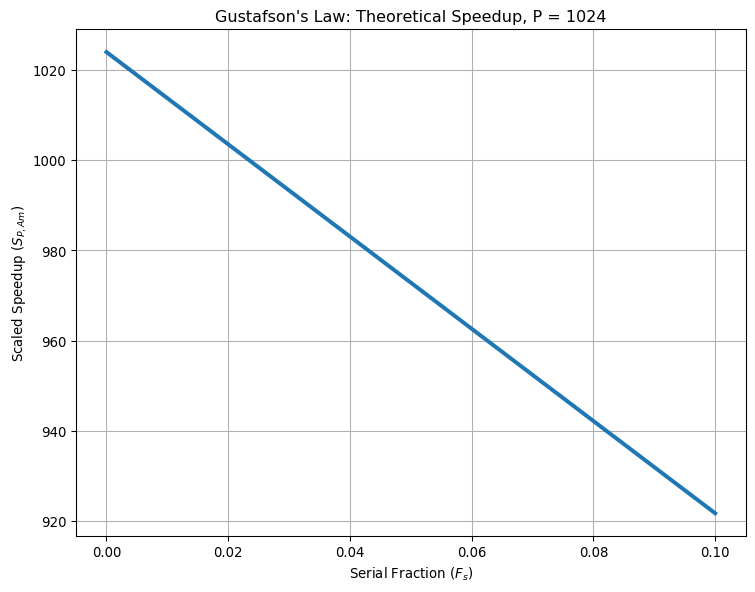

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# define the serial fraction using a linear space in NumPy
N = 101 # plotting grid resolution
F_s = np.linspace(0,0.1,N)
S_P_Gu = np.empty(N)

# set the number of processors
P = 1024
S_P_Gu[:] = float(P) + (1.0-float(P))*F_s[:]
plt.figure(figsize=(9,7), dpi=96)
plt.plot(F_s,S_P_Gu,'-', linewidth=3)
plt.xlabel(r"Serial Fraction ($F_s$)")
plt.ylabel(r"Scaled Speedup ($S_{P, Am}$)")
plt.title(r"Gustafson's Law: Theoretical Speedup, P = "+str(P))
plt.grid(True)

In practice, it is good to both test for weak and strong scaling of your program to see how the problem scales with the number of processors both for a fixed and proportionally growing problem size. In the next section, we will go through an example using matrix multiplication on how to do such an analysis.

## Example: Parallel Matrix-Vector Multiplication using Python

Next we will discuss an example of a matrix-vector multiplication algorithm  that we can build up to be parallel and how to evaluate its performance. Prior to evaluating parallel performance, we will first look at how to setup the algorithm in various methods using Python and try to optimize its serial performance first.


Consider an $m \times n$ matrix $A$ and $n \times 1$ vector $\vec{v}$. Multiplying $A$ with $\vec{v}$ results in a $m \times 1$ vector $\vec{b}$:

$$ A \vec{v} = \vec{b} $$


We begin by exploring serial performance, since we want to make sure we've done our best for its serial performance before moving on to improving it usuing parallelization.

### Serial Matrix-Vector Multiplicaton using Python

#### Pure Python Implementation

Due to being an interpreted language, Python is well known to have [poor performance with for-loops](https://stackoverflow.com/questions/8097408/why-python-is-so-slow-for-a-simple-for-loop), but for the sake of exercise, we're first going to implement this matrix-vector product in pure python. 
The pseudocode to compute this matrix-vector multiplication in serial looks like:

    Define matrix A(m,n)
    Define vector v(n,1)
    Define vector b(m,1) = 0 # Zero vector
    
    for i = 1 to m
        for j = 1 to n
            b(i,1) += A(i,j) * v(j, 1)
        end for
    end for
    
    
To write this in python, it looks like:

In [163]:
import random 

def rand_matrix_vector_mm_pure_python(m,n):
    # inputs:
    # m : number of rows
    # n : number of columns 
    # outputs:
    # b : m x 1 vector 

    # in pure python, we will use lists to store the values of the matrix and vectors
    # use random module to generate A and v
    A = [[random.random() for j in range(n)]   for i in range(m)]
    v = [random.random() for j in range(n)]

    b = []

    for i in range(0,m):
        b.append(0.0) # create next zero as a zero to setup for matrix-vector product storage.
        for j in range(0, n):
             b[i] += A[i][j] * v[j]
    return b

We can now test this Pure Python matrix-vector multiply's performance for a large 10000 x 10000 matrix:

In [179]:
%timeit rand_matrix_vector_mm_pure_python(10000,10000)

21.3 s ± 156 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We now have our baseline performance of a matrix-vector product using Pure Python.


#### NumPy Array Implementation

Next we can rewrite our function above, but now use NumPy arrays. We will also switch to numpy's built in random matrix function `random.rand()`. 



In [180]:
import numpy as np

def rand_matrix_vector_mm_np_array_loop(m,n):
    # inputs:
    # m : number of rows
    # n : number of columns 
    # outputs:
    # b : m x 1 vector 

    # in pure python, we will use lists to store the values of the matrix and vectors
    # use random module to generate A and v
    A = np.random.rand(m,n)
    v = np.random.rand(n,1)
    
    b = np.zeros((m,1))

    for i in range(0,m):
        for j in range(0, n):
             b[i] += A[i,j] * v[j]
    return b

If we time this function using a 10000 x 10000 matrix again, we see that our performance drops even more due to the for-loop using NumPy arrays:

In [181]:
%timeit rand_matrix_vector_mm_np_array_loop(10000,10000)

4min 13s ± 176 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


If we vectorize the inner loop and use a dot product, we can actually improve this performance:

In [157]:
import numpy as np

def rand_matrix_vector_mm_np_array_vectorize(m,n):
    # inputs:
    # m : number of rows
    # n : number of columns 
    # outputs:
    # b : m x 1 vector 

    # in pure python, we will use lists to store the values of the matrix and vectors
    # use random module to generate A and v
    A = np.random.rand(m,n)
    v = np.random.rand(n,1)

    b = np.zeros((m,1))
    for i in range(0,m):
        b[i] = np.dot(A[i,:],v[:]) 
    return b

In [183]:
%timeit rand_matrix_vector_mm_np_array_vectorize(10000,10000)

1.09 s ± 44.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


By removing the inner loop and utilizing NumPy's dot product function instead, we see an order of magnitude improvement over the Pure Python case, and 4 orders of magnitude performance over the NumPy Array-loop method. Can we do better than this?

#### NumPy's built-in Matrix-vector multiplication function: matmul()

Next we will remove the loops entirely and use NumPy's built-in matrix-multiplication function `matmul()':

In [172]:
import numpy as np

def rand_matrix_vector_mm_np_matmul(m,n):
    # inputs:
    # m : number of rows
    # n : number of columns 
    # outputs:
    # b : m x 1 vector 

    # in pure python, we will use lists to store the values of the matrix and vectors
    # use random module to generate A and v
    A = np.random.rand(m,n)
    v = np.random.rand(n,1)    

    b = np.zeros((m,1))
    b = np.matmul(A,v)
    return b

In [184]:
%timeit rand_matrix_vector_mm_np_matmul(10000,10000)

1.01 s ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Here we see a marginal improvement over removing the inner loop. However, there other available libraries in Python that could improve our performance!

#### Using Numba with NumPy

For more performance intensive tasks, the Python library [Numba](https://numba.pydata.org/) can yield potentially faster results in a serial case. 


In [177]:
from numba import *
import numpy as np

@jit(nopython=True)
def rand_matrix_vector_mm_np_matmul_numba(m,n):
    # inputs:
    # m : number of rows
    # n : number of columns 
    # outputs:
    # b : m x 1 vector 

    # in pure python, we will use lists to store the values of the matrix and vectors
    # use random module to generate A and v
    A = np.random.rand(m,n)
    v = np.random.rand(n,1)    

    b = np.zeros((m,1))
    b = np.dot(A,v)
    return b

In [185]:
%timeit rand_matrix_vector_mm_np_matmul_numba(10000,10000)

986 ms ± 6.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Again, we see some marginal improvement by adding in Numba's just-in-time (JIT) compiler. 


I hope we have made it clear that even taking a little time exploring alternatives for your serial performance will have implications for the parallel performance due to Amdahl's Law. 

There are other ways we could explore serial performance, which we did not explore here, can include:

* Reformulating the problem, such as using SciPy's [sparse matrices](https://docs.scipy.org/doc/scipy/reference/sparse.html) if your matrix has few non-zero entries
* Using a C-extension library such as [Cython](https://cython.org/) to port the floating point operation parts of the Python code to C
* Porting code completely to a low-level language such as C/C++ or Fortran

#### Row-wise Parallelization of  Matrix-vector multiplication in Python using MPI

There are many ways one could parallelize a matrix-vector multiplication. When using MPI, the best approach is to use the "Single Program, Multiple Data" (SPMD) model [5] of programming. This allows for multiple tasks to be broken up across multiple processors, but all communicated within a single program. 

A simple way to parallelize a matrix-vector product is is to break up the rows of the matrix into smaller matrices. Rows are favored over breaking up the columns since each column entry of $A$ is a vector which computes a dot product with the corresponding vector $\vec{v}$. 

We will divide the $m$ rows of the matrix A equally across all processors $P$, which we will denote by $A_{m_{local}, P}$. However, if $P$ does not divide by $m$ we need to determine what to do with the extra rows. To keep things simple, we will assume that the last processor $P-1$ will compute those extra rows. 

The submatrices on each processor will then be able to matrix multiply with $\vec{v}$ using NumPy's `matmul()` function without issue. There for for a given processor $P$, we obtain a local component of the final vector $\vec{b}_{local, P}$, which comes from:

$$ A_{m_{local}, P} \vec{v} = \vec{b}_{local, P} $$

Finally, to restruct the final solution, we will send all the $\vec{b}_{local,P}$'s from each processor $P$ to the "main" processor, which we call "rank 0". This can be done using `mpi4py` with its communicator `send()` and `recv()` commands. Since this is not a guide on `mpi4py` we will just show the final code below:

In [ ]:
import numpy as np
import sys
from mpi4py import MPI

start = MPI.Wtime()

# set up MPI communicator
comm = MPI.COMM_WORLD

# set variables to hold current rank (i.e. processor) and total number of processors
rank = comm.rank
nprocs = comm.Get_size()

#print("rank = ", rank, "nprocs=", nprocs)

# setup function which will compute our matrix vector product
def mat_mult_mpi(m,n):
    # inputs:
    # m : number of rows
    # n : number of columns
    # outputs:
    # b : m x 1 vector

    # get the local number of rows that a processor will store from the matrix
    # use the floor function to ensure we have a integer value
    m_local_size = int( np.floor( m / nprocs  ))

    # track the remainder of m dividing by nprocs
    rem = int( np.mod( m, nprocs ) )

    # if the remainder is nonzero, add that number of rows to the last processor to m_local_size
    if rem != 0 and rank == nprocs - 1:
        m_local_size += np.mod(m, nprocs)

    # use ones to generate A and v
    A = np.random.rand(m_local_size, n)
    v = np.random.rand(n,1)
    b_local = np.random.rand(m_local_size, 1)

    # use matmul to compute each component of the matrix-vector product for b
    b_local[:] = np.matmul(A,v)

    # send b_local to the main (0th) rank
    if rank != 0:
        comm.send(b_local, dest=0, tag=rank)

    b = np.zeros((m,1))

    # use the main rank (0th) to collect the entries of b using send/recv
    # for this version, we will use the pickled version of send/recv, which will show slower performance
    if rank == 0:
        # set b to b_local using the local rank indices
        b[rank*(m_local_size): (rank+1)*(m_local_size)] = b_local
        if nprocs != 1:
            for i in range(1, nprocs):
                if i == nprocs-1:
                    b[i*(m_local_size): (i+1)*(m_local_size)+rem] = comm.recv(source=i, tag=i)
                else:
                    b[i*(m_local_size): (i+1)*(m_local_size)] = comm.recv(source=i, tag=i)
        else:
            b = b_local
        return b

if __name__ == '__main__':
    m_size = int(3200)
    n_size = int(3200)
    b = mat_mult_mpi(m_size,n_size)
    #np.savetxt("b_"+str(nprocs)+".txt", b)
    #if rank == 0:
    #    print(b)
    # get wall time on given rank


end = MPI.Wtime()
Wtime= [end-start]
import csv
with open(str(nprocs)+"_Wtime_"+str(rank)+".txt",'a', newline='') as fd:
   writer = csv.writer(fd, delimiter=',')
   writer.writerow(Wtime)

From here, we run this code over a variety of number of processors to see how the performance increases. 


### Slurm Setup

To run the scaling analysis, we will use Slurm, the job manager used both on our Wendian and Mio HPC systems. 

The base bash Slurm script will look like:

In [ ]:
#!/bin/bash
#SBATCH --job-name=scaling_analysis    # Job name
#SBATCH --time=00:30:00               # Time limit hrs:min:sec
#SBATCH --output=test_%j.log   # Standard output and error log
#SBATCH --ntasks-per-node=1
#SBATCH -N 1
#SBATCH --mem=90GB
#SBATCH -A spr24_mpi4py_workshop
pwd; hostname; date

module purge
module load apps/python3
module load compilers/gcc
module load mpi/openmpi/gcc-cuda
conda activate mpi4py_workshop
export OMP_NUM_THREADS=1
export OMPI_MCA_btl_openib_allow_ib=1

EXE="srun python row_wise_mpi.py"

# measure time in milliseconds
START=$(date +%s.%N)
time $EXE
END=$(date +%s.%N)
RUNTIME=$(echo "$END - $START" | bc -l)
echo ${RUNTIME} >> ${SLURM_NPROCS}_runtime.txt
date

# References

[1] https://www.cs.uky.edu/~jzhang/CS621/chapter7.pdf  
[2] https://www.youtube.com/watch?v=pDBIoil-LTk  
[3] https://www-inst.eecs.berkeley.edu/~n252/paper/Amdahl.pdf  
[4] Gustafson, John L. "Reevaluating Amdahl's law." Communications of the ACM 31, no. 5 (1988): 532-533: http://www.johngustafson.net/pubs/pub13/amdahl.htm  
[5] https://xlinux.nist.gov/dads/HTML/singleprogrm.html